In [14]:
from apportionment import Apportionment
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

In [15]:
# Simulation parameters
voters = 1000000
num_seats = 150
nit = 100
group_size = 10000
link='NRSR2023_clean.csv'
file='test2811_11.csv'

ap = Apportionment(num_seats, voters, link=link) 
# -> TODO higher tresholds for coalitions
print("No of votes from source:", sum(ap.subject_votes.values()))
print("Considered votes:", ap.voters)
print("No. of seats:", num_seats)
weights = ap.subject_votes
# print(weights)

#apportionment test
result = ap.divide_seats("slovak")
if not (sum(result.values()) == 150): print(result.values()) 
else: print("seats ok")
if not (list(result.values()) == [32, 16, 11, 10, 42, 27, 12]): print(result.values()) 
else: print("apport ok")
print("Apportionment should work correctly.")

print("sum of probs:", sum(ap.probabilities.values()))
if not os.path.exists(file):
    ap.iterated_simulate('boxes', file, nit=nit, group_size=group_size)
else:
    print("Simulation did not happen, file already exists!")

link NRSR2023_clean.csv
No of votes from source: 4388872
Considered votes: 1000000
No. of seats: 150
seats ok
apport ok
Apportionment should work correctly.
sum of probs: 0.9999999999999998
Simulation did not happen, file already exists!


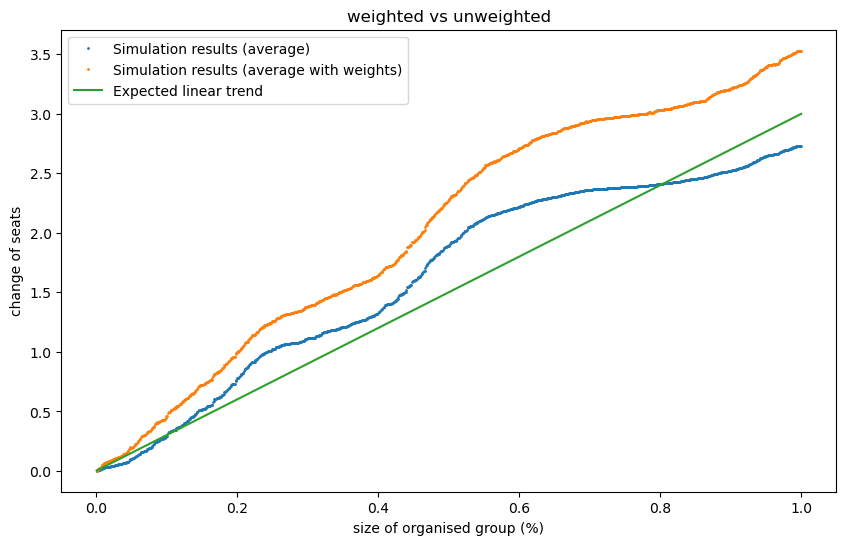

In [16]:
df = pd.read_csv('test2811_3.csv')
df['weight'] = df['party_number'].map(weights)

grouped_df = df.groupby('samples').mean().reset_index()
weighted_df = df.groupby('samples').apply(lambda x: np.average(x['diff'], weights=x['weight'])).reset_index(name='diff')

plt.figure(figsize=(10, 6))

x_values = grouped_df['samples']
y_values = grouped_df['diff']

plt.plot(x_values / 1000, y_values, 'o', markersize=1, label='Simulation results (average)')

x_values = weighted_df['samples']
y_values = weighted_df['diff']

plt.plot(x_values / 1000, y_values, 'o', markersize=1, label='Simulation results (average with weights)')

x = np.arange(1, 1001)
y = (3/1000) * x

plt.plot(x / 1000, y, label='Expected linear trend')
plt.xlabel('size of organised group (%)')
plt.ylabel('change of seats')
plt.title('weighted vs unweighted')

plt.legend()
plt.show()

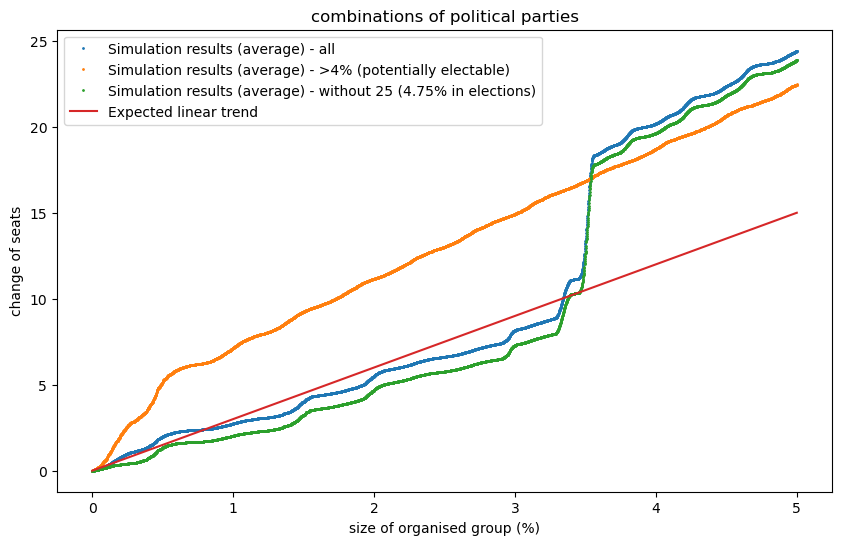

In [17]:
#POZN graf c 3
df = pd.read_csv('test2811_6.csv')

# display(df)
df4 = df.loc[(df['party_number'] == 0) | (df['party_number'] == 3) | (df['party_number'] == 5) | (df['party_number'] == 12) | (df['party_number'] == 15) | (df['party_number'] == 16) | (df['party_number'] == 17) | (df['party_number'] == 18) | (df['party_number'] == 23) | (df['party_number'] == 25)]
df0 = df.loc[df['party_number'] != 25] # 25 is edge case, almost got into parliament
df25 = df.loc[df['party_number'] == 25] 

weighted_df = df.groupby('samples').mean().reset_index()
weighted_df4 = df4.groupby('samples').mean().reset_index()
weighted_df0 = df0.groupby('samples').mean().reset_index()
weighted_df25 = df25.groupby('samples').mean().reset_index()


plt.figure(figsize=(10, 6))

x_values1 = weighted_df['samples']
y_values1 = weighted_df['diff']

plt.plot(x_values1 / 1000, y_values1, 'o', markersize=1, label='Simulation results (average) - all')

x_values = weighted_df4['samples']
y_values = weighted_df4['diff']

plt.plot(x_values / 1000, y_values, 'o', markersize=1, label='Simulation results (average) - >4% (potentially electable)')

x_values2 = weighted_df0['samples']
y_values2 = weighted_df0['diff']

plt.plot(x_values2 / 1000, y_values2, 'o', markersize=1, label='Simulation results (average) - without 25 (4.75% in elections)')

x = np.arange(1, 5001)
y = (3/1000) * x

plt.plot(x / 1000, y, label='Expected linear trend')
plt.xlabel('size of organised group (%)')
plt.ylabel('change of seats')
plt.title('combinations of political parties')

plt.legend()
plt.show()

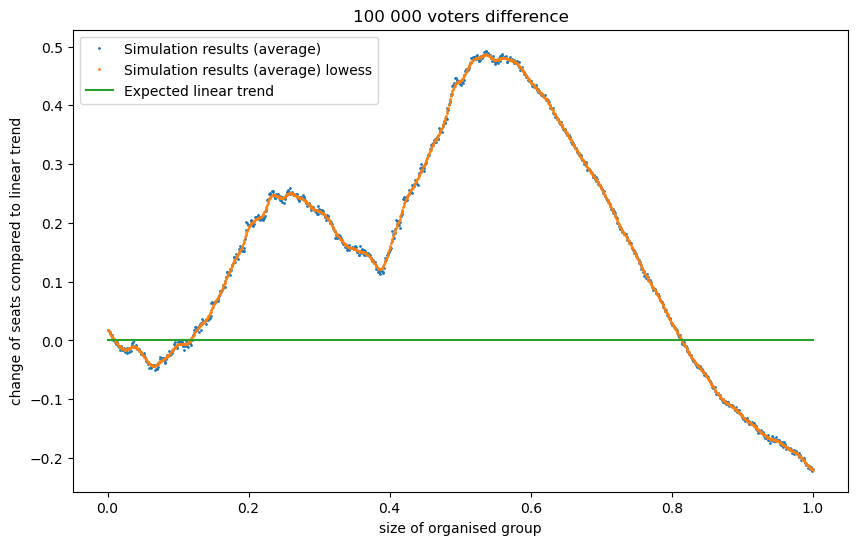

In [24]:


# z pridav DU 2
#src https://xavierbourretsicotte.github.io/loess.html?fbclid=IwAR0elgY3zYhAbB1jWxmwnJcv9nMbuc5BXHOhpUhCz4SQDgEZkoeiBwO6M9s

from scipy import linalg

def kernel_function(xi,x0,tau= .005): 
    return np.exp( - (xi - x0)**2/(2*tau)   )

def lowess_smooth(x, y, sigma = .005):
    x = np.arange(len(x))
    tau = sigma
    """lowess_bell_shape_kern(x, y, tau = .005) -> yest
    Locally weighted regression: fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The kernel function is the bell shaped function with parameter tau. Larger tau will result in a
    smoother curve. 
    """
    m = len(x)
    yest = np.zeros(m)

    #Initializing all weights from the bell shape kernel function    
    w = np.array([np.exp(- (x - x[i])**2/(2*tau)) for i in range(m)])     
    
    #Looping through all x-points
    for i in range(m):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        theta = linalg.solve(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 

    return yest


df= pd.read_csv('oldtest3.csv')

grouped_df = df.groupby('samples').mean()

plt.figure(figsize=(10, 6))

x_values = grouped_df.index
y_values = grouped_df['diff']

x = np.arange(1, 1001)
y = (3/1000) * x

plt.plot(x_values / 1000, y_values - y, 'o', markersize=1, label='Simulation results (average)')

sigma = 20
y_lowess = lowess_smooth(x, y_values - y, sigma)

plt.plot(x_values / 1000, y_lowess, 'o', markersize=1, label='Simulation results (average) lowess')


plt.plot(x / 1000, y * 0, label='Expected linear trend')



plt.xlabel('size of organised group')
plt.ylabel('change of seats compared to linear trend')
plt.title('100 000 voters difference')

plt.legend()
plt.show()




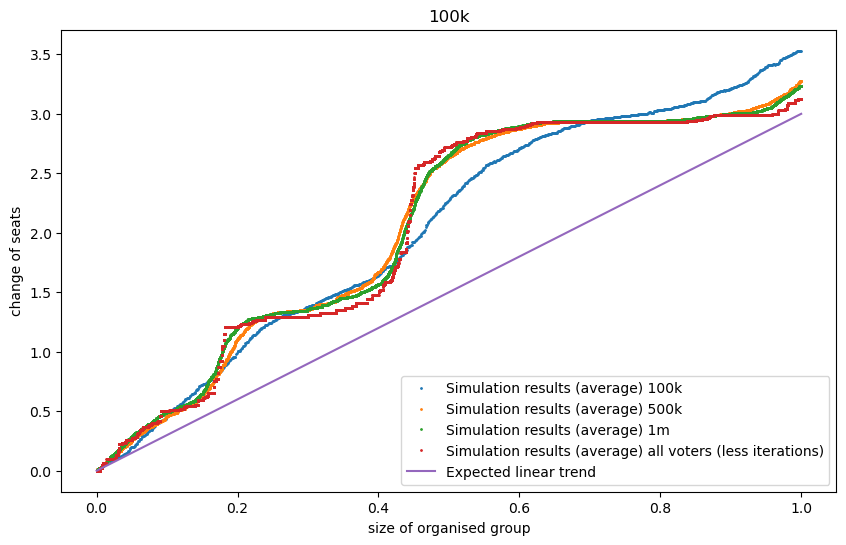

In [20]:
df1 = pd.read_csv('test2811_3.csv')
df2 = pd.read_csv('test2811_8.csv')
df3 = pd.read_csv('test2811_11.csv')
df4 = pd.read_csv('test2811_10.csv')

df1['weight'] = df1['party_number'].map(weights)
df2['weight'] = df2['party_number'].map(weights)
df3['weight'] = df3['party_number'].map(weights)
df4['weight'] = df4['party_number'].map(weights)

weighted_df1 = df1.groupby('samples').apply(lambda x: np.average(x['diff'], weights=x['weight'])).reset_index(name='diff')
weighted_df2 = df2.groupby('samples').apply(lambda x: np.average(x['diff'], weights=x['weight'])).reset_index(name='diff')
weighted_df3 = df3.groupby('samples').apply(lambda x: np.average(x['diff'], weights=x['weight'])).reset_index(name='diff')
weighted_df4 = df4.groupby('samples').apply(lambda x: np.average(x['diff'], weights=x['weight'])).reset_index(name='diff')

plt.figure(figsize=(10, 6))

x_values = weighted_df1['samples'] * 43.888
y_values = weighted_df1['diff']

plt.plot(x_values / 43889, y_values, 'o', markersize=1, label='Simulation results (average) 100k')

x_values = weighted_df2['samples'] * 8.7776
y_values = weighted_df2['diff']

plt.plot(x_values / 43889, y_values, 'o', markersize=1, label='Simulation results (average) 500k')

x_values = weighted_df3['samples'] * 4.3888
y_values = weighted_df3['diff']

plt.plot(x_values / 43889, y_values, 'o', markersize=1, label='Simulation results (average) 1m')

x_values = weighted_df4['samples']
y_values = weighted_df4['diff']

plt.plot(x_values / 43889, y_values, 'o', markersize=1, label='Simulation results (average) all voters (less iterations)')

x = np.arange(1, 43889)
y = (3/43888) * x

plt.plot(x / 43889, y, label='Expected linear trend')
plt.xlabel('size of organised group')
plt.ylabel('change of seats')
plt.title('100k')

plt.legend()
plt.show()